# Data set

Do przechowywania danych użyto SQLite, ze względu na jego komaptybilność z Rsutem i Reactem( w których projekt zostało napisany), prostą implementację, a szczególnie na szybki i nisko-kosztowny dostęp do danych. Jeśli miałby to być serwer z większą ilością zapytań to wybrałbym Mongo, ale tutaj dla offline, prostej i nie obsługującej dużej liczby zapytań jest baza SQL.


Dane pobrano ze strony: https://dumps.wikimedia.org/enwiki/latest/ 


Posłużono się wersją Simple Wiki [Eng]

Dane z pliku xml przeparsowano na pliki txt wikiextracotrem(https://github.com/attardi/wikiextractor) w lekko zmodyfikowanej wersji dla tego zadania


Oddzielnie wprowadzono dane z plików txt do bazy sqlite 

In [ ]:
import sqlite3
import re
import glob

def parse_file(file_path):
    docs = []
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        pattern = r'<doc id="(\d+)" url="(https?://[^"]+)" title="([^"]+)">([^<]+)<\/doc>'
        matches = re.findall(pattern, content)
        for match in matches:
            doc_id = match[0]
            url = match[1]
            title = match[2]
            text = match[3]
            docs.append((doc_id, title, url, text))
    return docs

def create_db_and_insert_data(docs):
    conn = sqlite3.connect('articles.db')
    cursor = conn.cursor()

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS articles (
            id INTEGER PRIMARY KEY,
            title TEXT,
            url TEXT,
            text TEXT
        )
    ''')

    cursor.executemany('''
        INSERT INTO articles (id, title, url, text)
        VALUES (?, ?, ?, ?)
    ''', docs)

    conn.commit()
    conn.close()

def main():
    folders = ['AA/*', 'AC/*', 'AB/*']
    for file in folders:
        file_paths = glob.glob(f)
        all_docs = []
        for file_path in file_paths:
            print(f'Przetwarzam plik: {file_path}')
            docs = parse_file(file_path)
            all_docs.extend(docs)

        if all_docs:
            create_db_and_insert_data(all_docs)
            print("Dane zostały zapisane w bazie danych.")
        else:
            print("Brak danych do zapisania.")

Alternatywna wersja rozwiazania( uzywanie api wikipedii i sciagnie losowych artykulow )

In [ ]:
# implementacja wspomagana przez AI
import sqlite3
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
from tqdm import tqdm

DATABASE_NAME = "wikipedia_fast.db"
WIKIPEDIA_API_URL = "https://en.wikipedia.org/w/api.php"
TARGET_ARTICLE_COUNT = 300000
THREADS = 50  
BATCH_SIZE = 500 

def init_db():
    conn = sqlite3.connect(DATABASE_NAME)
    cursor = conn.cursor()
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS articles (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        title TEXT UNIQUE,
        content TEXT
    )
    """)
    cursor.execute("CREATE INDEX IF NOT EXISTS idx_title ON articles(title)")
    conn.commit()
    conn.close()

def get_article_list(limit):
    params = {
        "action": "query",
        "format": "json",
        "list": "allpages",
        "aplimit": limit,
        "apfilterredir": "nonredirects"
    }
    response = requests.get(WIKIPEDIA_API_URL, params=params)
    data = response.json()
    return [page["title"] for page in data["query"]["allpages"]]

def fetch_article(title):
    try:
        params = {
            "action": "query",
            "format": "json",
            "prop": "extracts",
            "titles": title,
            "explaintext": True,
            "exsectionformat": "plain"
        }
        response = requests.get(WIKIPEDIA_API_URL, params=params, timeout=10)
        data = response.json()
        page = next(iter(data["query"]["pages"].values()))
        return (title, page.get("extract", ""))
    except:
        return None

def save_batch(batch):
    conn = sqlite3.connect(DATABASE_NAME)
    cursor = conn.cursor()
    cursor.executemany(
        "INSERT OR IGNORE INTO articles (title, content) VALUES (?, ?)",
        [(title, content) for title, content in batch if content]
    )
    conn.commit()
    conn.close()

def main():
    init_db()
    
    conn = sqlite3.connect(DATABASE_NAME)
    cursor = conn.cursor()
    cursor.execute("SELECT COUNT(*) FROM articles")
    existing = cursor.fetchone()[0]
    conn.close()
    
    if existing >= TARGET_ARTICLE_COUNT: return
    
    needed = TARGET_ARTICLE_COUNT - existing
    
    print("Pobieranie...")
    articles = get_article_list(needed * 2)
    articles = articles[:needed + 10000] 
    
    batch = []
    start_time = time.time()
    
    with ThreadPoolExecutor(max_workers=THREADS) as executor:
        futures = {executor.submit(fetch_article, title): title for title in articles}
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Pob"):
            result = future.result()
            if result:
                batch.append(result)
                
                if len(batch) >= BATCH_SIZE:
                    save_batch(batch)
                    batch = []
    
    if batch:
        save_batch(batch)
    
    elapsed = time.time() - start_time
    print(f"Zakonczono w {elapsed:.2f} seknd")

Prosty Web scraper( nie uzyty, bo dziala za wolno)

In [ ]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import time

NUM_ARTICLES = 300000

conn = sqlite3.connect('articles.db')
cursor = conn.cursor()

cursor.execute('''
    CREATE TABLE IF NOT EXISTS articles (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        url TEXT UNIQUE,
        title TEXT,
        text TEXT
    )
''')

def scrape_random_article():
    try:
        response = requests.get('https://pl.wikipedia.org/wiki/Special:Random', allow_redirects=True)
        final_url = response.url 
        soup = BeautifulSoup(response.text, 'html.parser')
        title = soup.find('h1').get_text()
        paragraphs = soup.select('div.mw-parser-output > p')
        text = '\n'.join(p.get_text() for p in paragraphs if p.get_text(strip=True))
        return final_url, title, text
    except Exception as e:
        print(f"Error: {e}")
        return None, None, None

for _ in range(NUM_ARTICLES):
    url, title, text = scrape_random_article()
    if title and text:
        try:
            cursor.execute(
                'INSERT INTO articles (url, title, text) VALUES (?, ?, ?)',
                (url, title, text)
            )
            conn.commit()
        except sqlite3.IntegrityError:
    time.sleep(1)  # zeby nie zablokowac serwera

conn.close()


Łącznie użyto ~350k dokumentów ( 370847), a słownik zawierał ~500k słów (494618)

# Frontend
Implementacja w React, kod i szczegóły dependecies itd są na githubie

W Reacie jest liczony czas trwania obliczen( odpowiedzi od API), bo uznałem że w tym miejscu będzie bardziej odzwierciedlał rzeczywisty czas oczekiwania użytkownika na odpowiedź podczas wyszukiwania


# Backend

Realizowany w Ruscie

Do komunikacji z frontem użyto Actix

Uzyto Rust ze wzgledu na jego niskopoziomowa szybkosc i bezpieczne i szybkie zarzadznie pamiecią, kluczowe w tym zagadnieniu. Rust ma swoje minusy( brak implementacji użytecznych bibliotek) i plusy(sprawna wielowątkowość), co przy prędkość porównywalnej do C/C++ czyni go dobrym narzędziem do tego typu problemów.

Jeszcze przed rozpoczęciem obliczeń stowrzono plik stop_words, który wyelimunej nam nieużyteczne słowa.

Dodatkowo zaimplementowano Porter Stemming Algorithm do przekształcenia wspólnych końcówek morfologicznych i fleksyjnych

Następnie zaimplementowany parser, który pobiera dane z bazy SQL i przerabia je na strukture Document

Pozniej zakodowano tokenizer, ktorzy stowrzy alfabet uwzgledniajaca stop_words

Budowanie macierzy i IDF (bez SVD)

Znajdowanie cosinusowego podobienstwa

### Analiza podejscia pierwszego

Bez svg, branch version_1

Build cargo: 2min

Czas kompilacji Rust: 10s

Czas obliczania macierzy: 10-20 min ( tak dlugi czas spowodowany glownie stemmingiem)

#### Wydajnosc

Wyniki będą zależne od czasu wyszukiwania , wyniku najlepszego dopasowania i dlugości frazy wprowadzonej.
Pierwsza czesc wynikow sprawdzana recznie( dla fraz zawierających słowa bardziej popularne), druga automatycznie dla słów mniej używanych

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# czas wyszukiwania
T = [0.36,0.7,0.7,0.69,0.2,0.66,0.8,0.73,0.33,0.4] 
T2 = [0.21605043406104615, 0.8418330508758792, 0.21824175990451766, 0.46123812638799067, 0.4896324212071994, 0.3085971535594555, 0.5729169307521162, 0.7004299566217758, 0.557175083332112, 0.5216559948211459, 0.7823143234314931, 0.803018503802912, 0.8359281056626182, 0.49754793710318723, 0.35930416477057736, 0.26612096419051756, 0.6707278325322514, 0.5641462929677329, 0.20230972369505673, 0.6752079496931762]
# najlepszy score ( najlepszy wynik)
S = [1,1,1,0.91,0,0.7,0.5,0.27,0.6,0.67]
S2 = [0.7652311289067941, 0.2429320644734682, 0.22617432581760433, 0.612170294639504, 0.3398229072715203, 0.8766928662392541, 0.9153821064607186, 0.597563239722608, 0.37877688615648003, 0.7955212033369589, 0.6988274272927444, 0.9385395205667126, 0.9148754266117226, 0.6680856024658938, 0.48268289799754927, 0.06606377241090465, 0.8599775459184772, 0.8850187301018148, 0.8605851306989336, 0.8083077888648176]
# długość wpisywanie frazy
L = [1,1,3,2,1,4,3,3,2,2] 
L2 = [4, 1, 3, 1, 1, 1, 3, 2, 1, 2, 3, 1, 5, 2, 4, 4, 2, 2, 4, 3]

In [8]:
def draw_plot(T,S,L):
        
    plt.figure(figsize=(15, 10))

    # Wykres 1: T vs S (czas vs score)
    plt.subplot(2, 2, 1)
    plt.scatter(T, S, c='blue')
    plt.title("Czas wyszukiwania vs Score")
    plt.xlabel("Czas wyszukiwania (T)")
    plt.ylabel("Score (S)")

    # Wykres 2: L vs T (długość frazy vs czas)
    plt.subplot(2, 2, 2)
    plt.scatter(L, T, c='green')
    plt.title("Długość frazy vs Czas wyszukiwania")
    plt.xlabel("Długość frazy (L)")
    plt.ylabel("Czas wyszukiwania (T)")

    # Wykres 3: L vs S (długość frazy vs score)
    plt.subplot(2, 2, 3)
    plt.scatter(L, S, c='red')
    plt.title("Długość frazy vs Score")
    plt.xlabel("Długość frazy (L)")
    plt.ylabel("Score (S)")

    # Wykres 4: Trójwymiarowy wykres jako kolor punktów zależny od L
    plt.subplot(2, 2, 4)
    scatter = plt.scatter(T, S, c=L, cmap='viridis')
    plt.colorbar(scatter, label="Długość frazy (L)")
    plt.title("Czas vs Score z kolorem = Długość frazy")
    plt.xlabel("Czas wyszukiwania (T)")
    plt.ylabel("Score (S)")

    plt.tight_layout()
    plt.show()

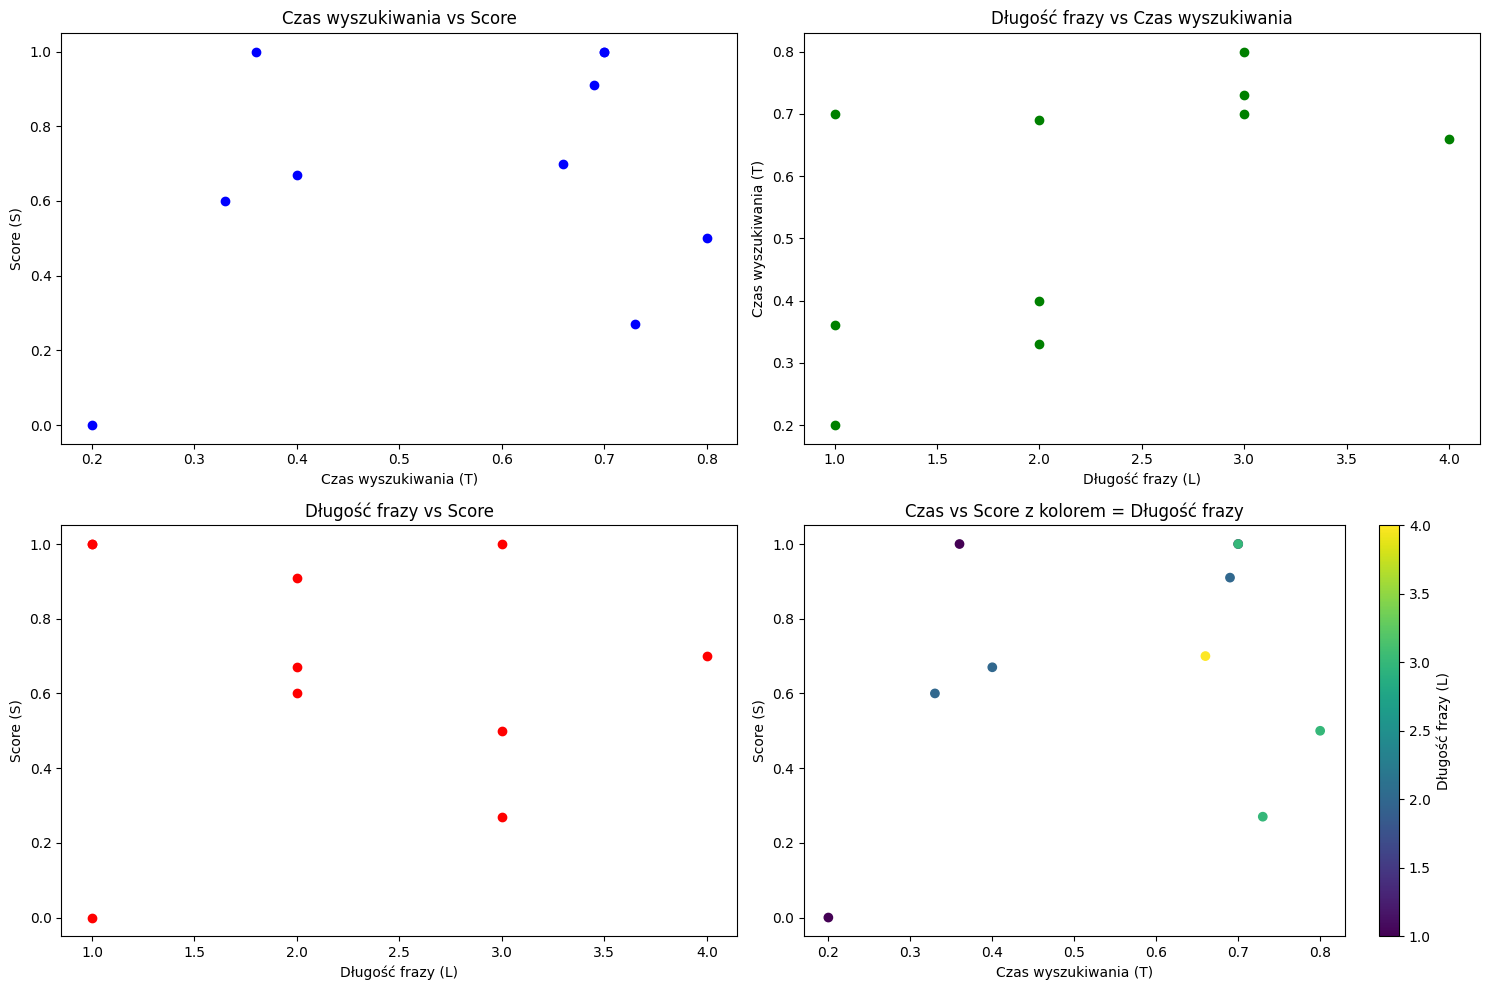

In [ ]:
# Tylko pierwsza część testowa
draw_plot(T,S,L)
# Dla popularniejszych fraz score był odwrotnie proporcjonlany do długości wpisywanej fraz, czas wyszukiwania był różny( zależny o ilość wystąpień w data secie)
# Dla dłuższych fraz czas wyszukiwania był większy, jednak dłuższy czas wyszukiwania nie świadczył jednocznacznie o lepszym scorze

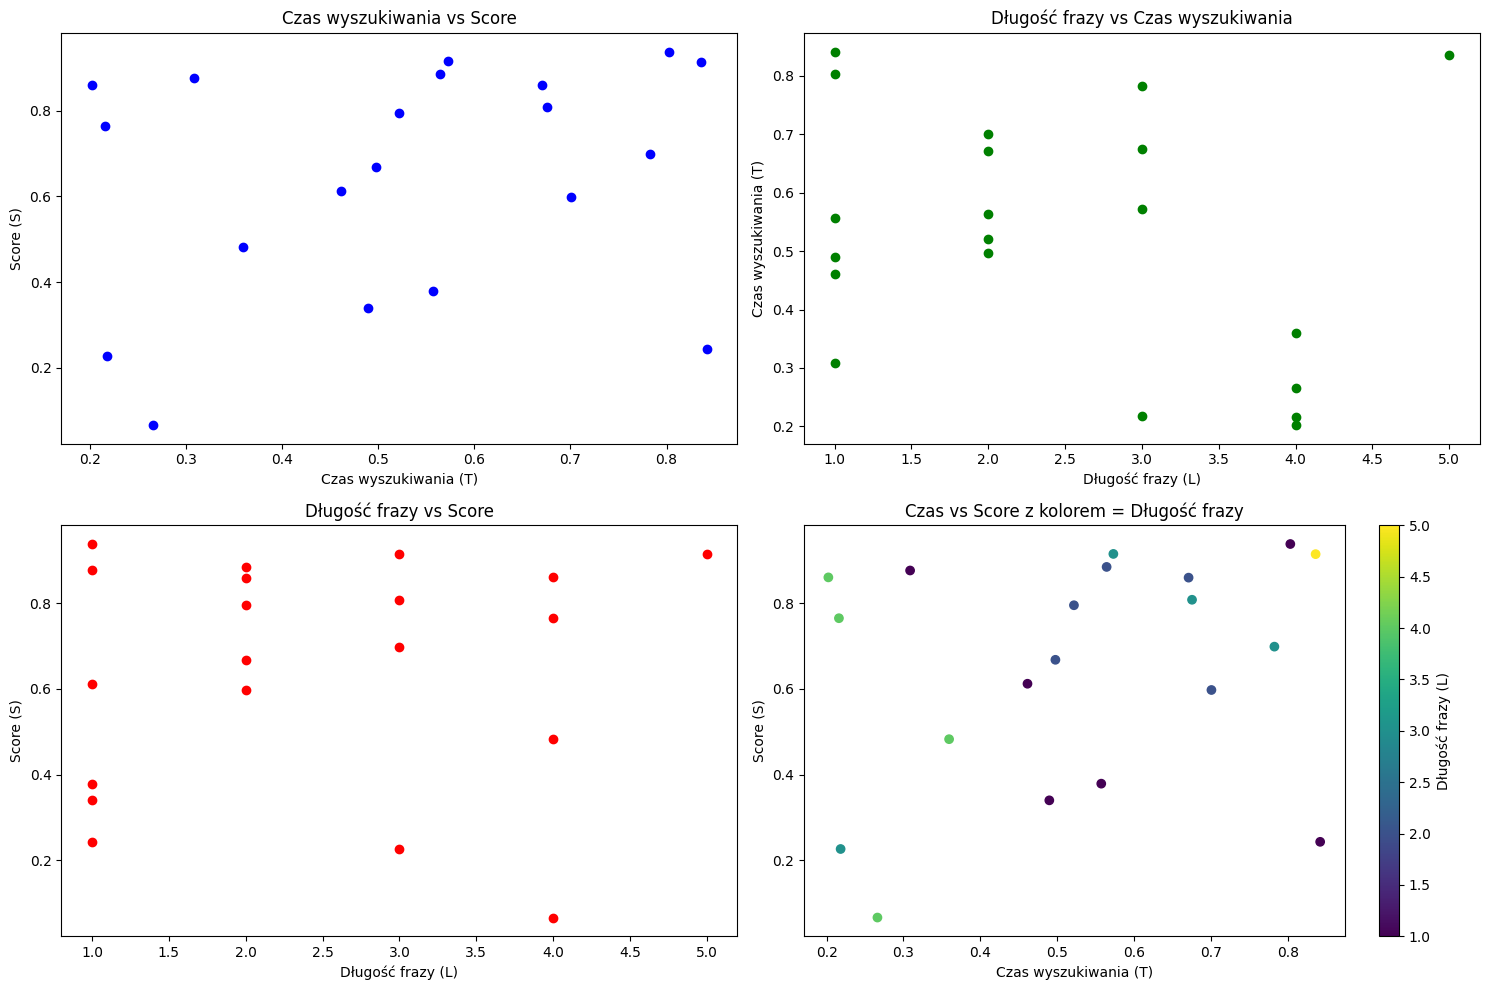

In [ ]:
# Frazy rzadsze
draw_plot(T2,S2,L2)
# Tutaj wszystkie próby już osiągnęły znacznie niższe scory, czas wyszukiwania był zależny od długości frazy

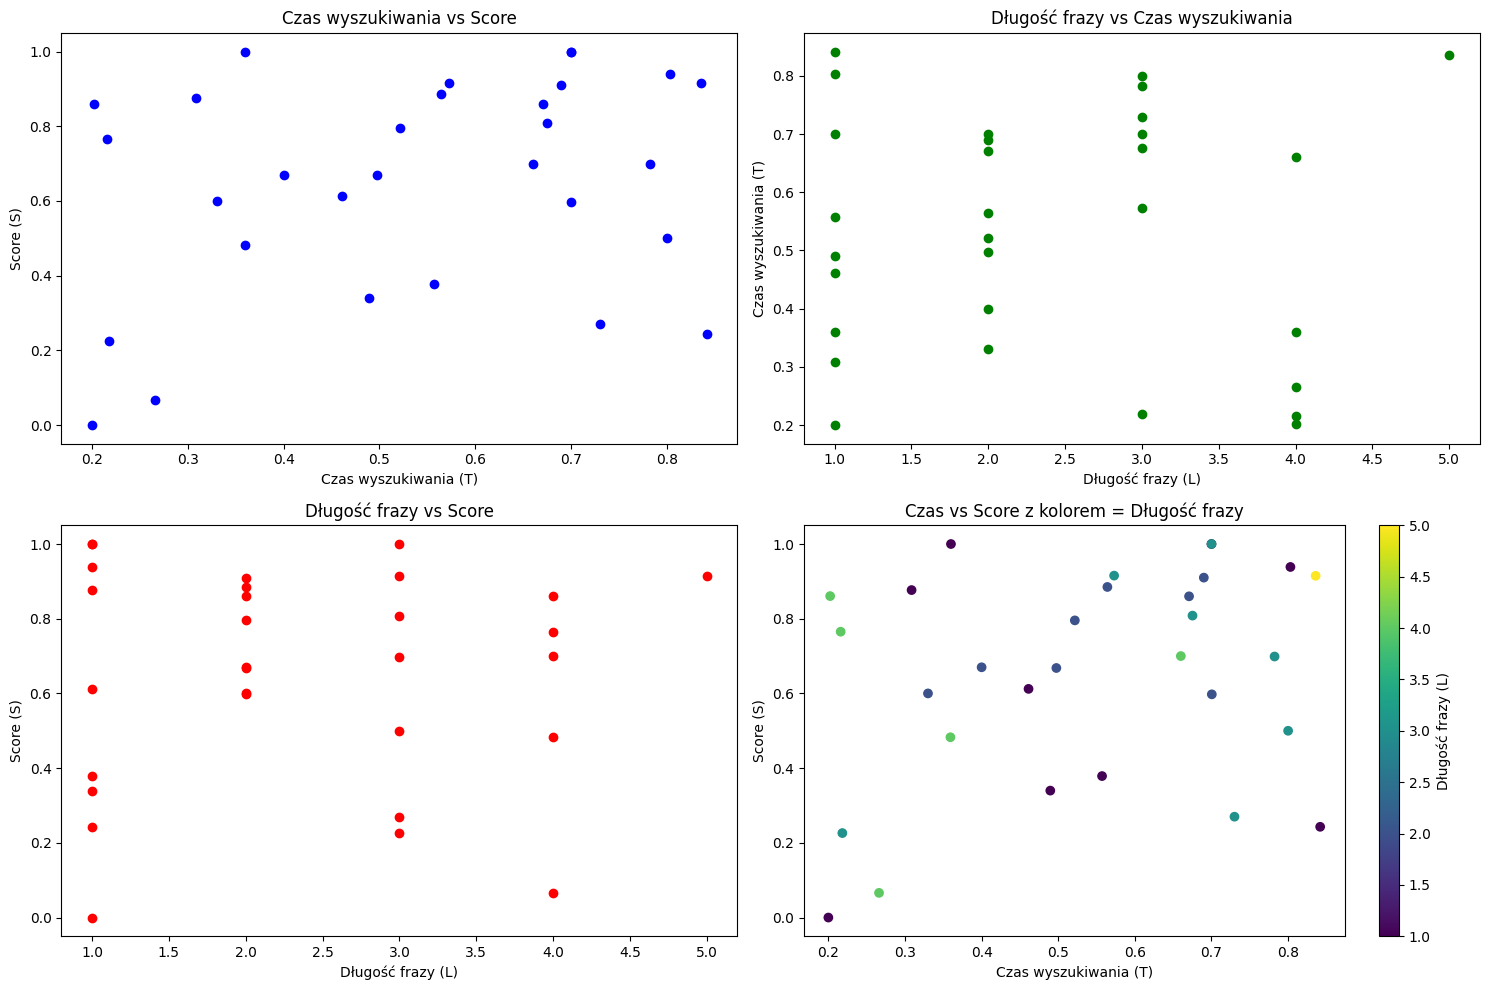

In [ ]:
# Połączone
draw_plot(T+T2,S+S2,L+L2)
# Dłuższy czas wyszukiwania głównie świadczył o lepszym scorze, długość frazy też wpływała na wyniki wyszukiwania

### Podjeście drugie

W tym podejsciu użyejmy SVD( 8 i 9 punkt konspektu), branch version_2

Build cargo: 3min

Czas kompilacji Rust: 13s

Czas obliczania macierzy: 25min

#### Wydajnosc

Do porównania wydajności użyjemy tylko tych samych zapytań, którymi posłużyliśmy się w pierwszym podjeściu oraz podobnych losowych rzadszych zapytań